In [6]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from qini_curve import qini_df
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

In [7]:
df["old_target"] = 1

df.loc[df["target_class"].isin([0, 2]), "old_target"] = 0

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

In [8]:
df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
2052,12,42.76,1,0,1,0,0,1,0,0,1,0,0.477596,0.002233,0.492098,0.028073,0.098630,0,0
9188,3,236.74,1,1,0,0,1,0,0,0,1,0,0.338212,0.149336,0.319221,0.193231,0.141542,1,1
6079,4,46.65,1,0,1,1,0,0,1,0,0,1,0.430861,0.026719,0.436040,0.106380,0.275457,2,0
9711,1,349.65,1,0,0,0,1,0,0,0,0,1,0.421712,0.128117,0.272425,0.177745,0.323655,1,1
11499,9,155.39,0,1,1,0,0,1,0,0,0,1,0.491633,0.014481,0.447632,0.046254,0.130083,0,0


In [ ]:
from causalml.inference.meta import BaseSClassifier
from sklearn.linear_model import LogisticRegression

s_learner = BaseSClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
# # оцените качество

df_test["uplift_vals"] = uplift_vals

array([[0.06375848],
       [0.06572021],
       [0.06644341],
       ...,
       [0.04883633],
       [0.04192827],
       [0.07620713]], shape=(3196, 1))

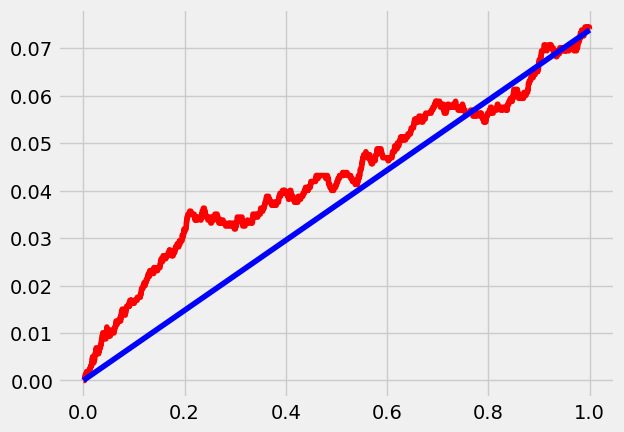

np.float64(19.109590000000004)

In [5]:
qini_df(df_test)

In [ ]:
from causalml.inference.meta import BaseTClassifier
from sklearn.linear_model import LogisticRegression

t_learner = BaseTClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))
# оцените качество

df_test["uplift_vals"] = uplift_vals

Learning rate set to 0.052448
0:	learn: 0.3124786	total: 51.7ms	remaining: 51.7s
1:	learn: 0.3119479	total: 52.8ms	remaining: 26.3s
2:	learn: 0.3114392	total: 53.3ms	remaining: 17.7s
3:	learn: 0.3108865	total: 53.9ms	remaining: 13.4s
4:	learn: 0.3104456	total: 54.5ms	remaining: 10.8s
5:	learn: 0.3100068	total: 55ms	remaining: 9.11s
6:	learn: 0.3096512	total: 55.5ms	remaining: 7.87s
7:	learn: 0.3093568	total: 56.1ms	remaining: 6.95s
8:	learn: 0.3089837	total: 56.7ms	remaining: 6.25s
9:	learn: 0.3086615	total: 57.3ms	remaining: 5.67s
10:	learn: 0.3084225	total: 57.9ms	remaining: 5.21s
11:	learn: 0.3080876	total: 58.5ms	remaining: 4.82s
12:	learn: 0.3078538	total: 59.2ms	remaining: 4.49s
13:	learn: 0.3076229	total: 59.8ms	remaining: 4.21s
14:	learn: 0.3073816	total: 60.3ms	remaining: 3.96s
15:	learn: 0.3071500	total: 61.3ms	remaining: 3.77s
16:	learn: 0.3069334	total: 62.1ms	remaining: 3.59s
17:	learn: 0.3067826	total: 62.7ms	remaining: 3.42s
18:	learn: 0.3066002	total: 63.2ms	remaining: 

AttributeError: 'CatBoostRegressor' object has no attribute 'predict_proba'

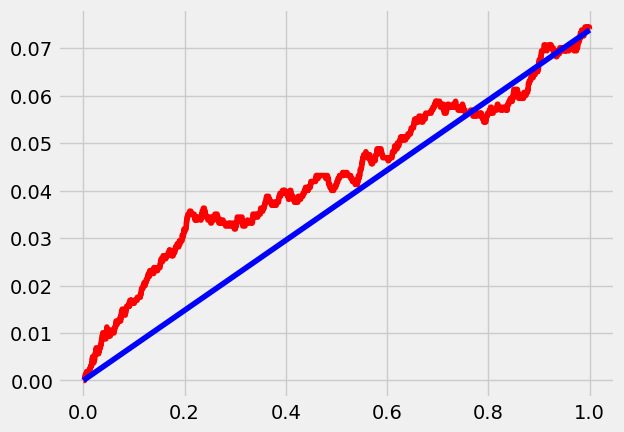

np.float64(19.109590000000004)

In [5]:
qini_df(df_test)